In [94]:
from pettingzoo.mpe import simple_spread_v2
from pettingzoo.utils import AssertOutOfBoundsWrapper
from pettingzoo.utils import aec_to_parallel

import time
import pettingzoo
pettingzoo.__version__
import sys
import torch  
import gym
# from tqdm import tqdm
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [95]:
class A2CTD0:
    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma) -> None:
        self.env = env
        self.obs_size = obs_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_episodes = num_episodes
        self.num_steps = num_steps
        self.gamma = gamma

        # self.model = ActorCriticSingleAgent(self.obs_size * self.env.observation_space.shape[0] + 1, self.output_size, self.hidden_size, self.learning_rate)
    
    def _get_action(self, actor_act_pred):
        # Sample an action according the probs the network just output.
        action = np.random.choice(self.output_size, p=np.squeeze(actor_act_pred))
        return action

    def _obs_to_tensor(self, obs):
        state_tensor = torch.flatten(F.one_hot(torch.tensor(obs, dtype=torch.int64), num_classes=self.obs_size))
        # add a bias bit with a value of 1 in front of the one hot vector
        state_tensor = torch.cat((torch.tensor([1.0]), state_tensor))
        return state_tensor

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths, frequency):
        if episode % frequency == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            state_values = np.zeros((10, 10))
            for i in range(1, 11):
                for j in range(1, 11):
                    state_tensor = self._obs_to_tensor([i, j])
                    value, _ = self.model.forward(state_tensor.float())
                    state_values[i-1][j-1] = value.detach().numpy()
            # show the value of each state with matplot lib
            # plt.imshow(state_values)
            # plt.show()
                # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) 
                # + "\nCurrent State: " + str(state)
                )
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: {}, total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            rewards = []
            done = False
            i = 1

            state = self.env.reset()
            steps = 0
            # enable n step actor critic. 
            while not done:
                state_tensor = self._obs_to_tensor(state)
                critic_td_error, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)

                # Calculate the log probability of the action we've taken
                log_prob = torch.distributions.Categorical(actor_act_pred).log_prob(torch.tensor(action))

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                new_state, reward, done, _, _ = self.env.step(action)
                steps += 1

                state = new_state
                
                state_tensor = self._obs_to_tensor(state)
                if not done:
                  q_val_tensor, _ = self.model.forward(state_tensor.float())
                else:
                    q_val_tensor = torch.tensor(0)
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                td_error = reward + self.gamma * q_val_tensor - critic_td_error
        
                # update actor critic
                actor_loss = -log_prob * (reward + self.gamma * q_val_tensor.item() - critic_td_error.item())
                actor_loss *= i
                critic_loss = 0.5 * td_error ** 2
                critic_loss *= i

                ac_loss = actor_loss + critic_loss + 0.001 * entropy

                ac_optimizer.zero_grad()
                ac_loss.backward()
                ac_optimizer.step()
                # all_entropies.append(entropy)
                all_losses.append(ac_loss.detach().numpy())
                i *= self.gamma
            if done:
              episode_rewards.append(np.sum(rewards))
            self._show_episode_results(episode, steps, state, all_losses, average_lengths)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [96]:
"""
This is a single agent actor-critic implementation.
It is specifically designed to work with the four rooms environment, but it should work with any gym environment.
"""

import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd


def obs_to_tensor(obs: np.array) -> torch.Tensor:
    # initialize an empty np array
    obs_tensor = np.array([])
    for _, value in obs.items():
        obs_tensor = np.concatenate((obs_tensor, value))
    return torch.Tensor(obs_tensor)



In [97]:
class ActorCriticCentralizedMultiAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, actions_per_agent, hidden_size, learning_rate=3e-4):
        super(ActorCriticCentralizedMultiAgent, self).__init__()

        self.num_actions = num_actions
        self.actions_per_agent = actions_per_agent
        # estimate the value function
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, hidden_size)
        self.critic_linear3 = nn.Linear(hidden_size, len(self.actions_per_agent))

        # estimate the policy distribution
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, hidden_size)
        self.actor_linear3 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        # softmax effectively generates a probability for each of our output options
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = self.actor_linear3(policy_dist)
        # reshape the policy dist for each actor
        policy_dist = policy_dist.view((len(self.actions_per_agent), self.actions_per_agent[0]))

        policy_dist = F.softmax(policy_dist, 1)

        return value, policy_dist

In [173]:
min_vals = np.zeros((6))
max_vals = np.zeros((6))
min_adj = np.ones((6))
max_adj = np.zeros((6))

class A2CTDNCentralizedMultiAgent(A2CTD0):
    def __init__(self, env, obs_size, hidden_size, output_size, actions_per_agent, learning_rate, num_episodes, num_steps, gamma, use_entropy=False) -> None:
        super().__init__(env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma)
        self.actions_per_agent = actions_per_agent
        self.use_entropy = use_entropy

        self.model = ActorCriticCentralizedMultiAgent(self.obs_size + 1, self.output_size, actions_per_agent, self.hidden_size, self.learning_rate)
    
    def _get_actions(self, actor_act_pred, num_agents):
        # Sample an action according the probs the network just output.
        idx = 0
        actions = {}
        for agent in self.env.agents:
            action_space_size = self.env.action_space(agent).n
            action = np.random.choice(action_space_size, p=np.squeeze(actor_act_pred[idx]))
            actions[agent] = action
            idx += 1
        return actions

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths, rewards, frequency):
        if episode % frequency == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            # state_values = np.zeros((10, 10))
            # for i in range(1, 11):
            #     for j in range(1, 11):
            #         state_tensor = self._obs_to_tensor([i, j])
            #         value, _ = self.model.forward(state_tensor.float())
            #         state_values[i-1][j-1] = value.detach().numpy()
            # # show the value of each state with matplot lib
            # # plt.imshow(state_values)
            # # plt.show()
            #     # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) + "\nRewards: " + str(rewards[-1]) + "\n" + "Average last 20 Rewards" + str(np.mean(rewards[-20:])))
                # + "\nCurrent State: " + str(state))
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: " + str(episode))
            # global min_vals, max_vals, min_adj, max_adj
            # sys.stdout.write("\nmin_vals: " + str(min_vals))
            # sys.stdout.write("\nmax_vals: " + str(max_vals))
            # sys.stdout.write("\nmin_adj: " + str(min_adj))
            # sys.stdout.write("\nmax_adj: " + str(max_adj))
            #total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def _obs_to_tensor(self, obs: np.array) -> torch.Tensor:
        # initialize an empty np array
        # we want to normalize these values so they are above 0
        # The form is: [agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos + comm
        # first we'll just adjust the position of the agent from -1 - 1 to 0 - 1
        # This means the second and third obs values for each agent must be added by 1 and then divided by 2
        obs_tensor = np.array([1.0])
        # global min_vals, max_vals
        # # track the min and max values for each observation
        # for i, value in enumerate(list(obs.values())[0]):
        #     if value < min_vals[i]:
        #         min_vals[i] = value
        #     if value > max_vals[i]:
        #         max_vals[i] = value

        for _, value in obs.items():
            new_array = np.concatenate([np.array(value[0:2] + 2) / 4, np.array((value[2:4]  + 25) / 50), (np.array(value[4:]) + 25) / 50])
            # global min_adj, max_adj
            # for i, val in enumerate(list(new_array)):
            #     if val < min_adj[i]:
            #         min_adj[i] = val
            #     if val > max_adj[i]:
            #         max_adj[i] = val

            obs_tensor = np.concatenate((obs_tensor, value))
        return torch.Tensor(obs_tensor)

    def _combine_rewards(self, rewards):
        """
        Push the rewards into a tensor that can be handled by pytorch
        """
        return np.array(list(rewards.values())).T

    def _get_log_probs(self, actor_act_pred, actions):
        start = 0
        log_probs = []
        for agent in self.env.agents:
            action_space_size = self.env.action_space(agent).n
            log_probs.append(torch.distributions.Categorical(actor_act_pred[start: start + action_space_size]).log_prob(torch.tensor(actions[agent])))
            start += action_space_size
        return torch.concatenate(log_probs)

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            single_episode_rewards = []
            done = False
            i = 1
            G = 0
            state = self.env.reset()
            steps = 0
            step_rewards = []
            states = [state]
            dones = []
            actions = []

            # enable n step actor critic. 
            while True:
                state_tensor = self._obs_to_tensor(state)
                _, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_actions(detached_act_pred, len(self.env.agents))

                actions.append(action)

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                # entropy_term += entropy
                new_state, rewards, done, _, _ = self.env.step(action)
                # time.sleep(.05)
                # done is a dict of agents. We only care if all agents are done
                single_episode_rewards.append(np.sum(list(rewards.values())))
                done = all(done.values()) or len(self.env.agents) < 1
                if done:
                    break
                steps += 1

                state = new_state
                step_rewards.append(self._combine_rewards(rewards))
                dones.append(done)
                states.append(new_state)

                if len(step_rewards) >= self.num_steps:
                    if len(step_rewards) > self.num_steps:
                        step_rewards.pop(0)
                        states.pop(0)
                        dones.pop(0)
                        actions.pop(0)

                    # calculate G
                    G = 0
                    for idx, r in enumerate(step_rewards):
                        # account for the dones vector too
                        G += r * (self.gamma ** idx) * (1 - dones[idx])

                    critic_val, actor_act_pred = self.model.forward(self._obs_to_tensor(states[0]).float())
                    if len(self.env.agents) < 1:
                        print('where agent')
                    log_probs = self._get_log_probs(actor_act_pred, actions[0])
                    next_state_tensor = self._obs_to_tensor(states[-1])
                    if not dones[0]:
                        next_critic_value_tensor, _ = self.model.forward(next_state_tensor.float())
                    else:
                        # set a zeros tensor equal to the length of the number of agents
                        next_critic_value_tensor = torch.zeros(len(self.env.agents))
                    # calculate the n step td error
                    # td error = G + gamma ** self.num_steps * V(s_{t+n}) - V(s_t)
                    td_error = torch.tensor(G) + self.gamma ** self.num_steps * next_critic_value_tensor - critic_val


                    # update actor critic
                    actor_loss = -log_probs * (torch.tensor(G).detach() + self.gamma * next_critic_value_tensor.detach() - critic_val.detach())
                    actor_loss *= i
                    critic_loss = 0.5 * td_error ** 2

                    ac_loss = actor_loss + critic_loss
                    if self.use_entropy:
                        # check if entropy is nan or inf
                        if entropy == np.nan or entropy == np.inf:
                            entropy = 0
                        ac_loss += 0.001 * entropy

                    ac_optimizer.zero_grad()
                    ac_loss.backward(
                        torch.ones_like(ac_loss)
                    )
                    ac_optimizer.step()
                    # all_entropies.append(entropy)
                    all_losses.append(ac_loss.detach().numpy())
                    i *= self.gamma


            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            discounted_episode_reward = 0
            for reward in single_episode_rewards[::-1]:
                discounted_episode_reward = reward + self.gamma * discounted_episode_reward
            episode_rewards.append(discounted_episode_reward)
            self._show_episode_results(episode, steps, states, all_losses, average_lengths, episode_rewards, 1000)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [174]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [176]:
def run_it(num_steps, max_episodes, num_agents, use_entropy=False):
    hidden_size = 64
    learning_rate = 3e-4

    # Constants
    gamma = 0.99

    env = simple_spread_v2.env(N=num_agents, local_ratio=0.5, max_cycles=25, continuous_actions=False, 
    # render_mode="human"
    )

    env = AssertOutOfBoundsWrapper(env)
    env = aec_to_parallel(env)

    obs_dict = env.reset()
    state = env.state()
    # env.render()
    obs_size = obs_to_tensor(obs_dict).shape[0]
    output_size = 0
    actions_per_agent = []

    for i in range(len(env.agents)):
        output_size += env.action_space(env.agents[i]).n
        actions_per_agent.append(env.action_space(list(obs_dict.keys())[i]).n)

    many_run_lengths, many_run_average_lengths, many_run_entropies, many_run_losses, many_run_rewards = [], [], [], [], []

    for i in range(3):
        agent = A2CTDNCentralizedMultiAgent(env, obs_size, hidden_size, output_size, actions_per_agent, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma, use_entropy=use_entropy)

        all_lengths, average_lengths, all_entropies, all_losses, episode_rewards = agent.train()
        # many_run_lengths.append(all_lengths)
        # many_run_average_lengths.append(average_lengths)
        # many_run_entropies.append(all_entropies)
        many_run_losses.append(np.sum(np.array(all_losses), 1))
        many_run_rewards.append(np.array(episode_rewards))
    return many_run_losses, many_run_rewards


In [103]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 15000
    num_agents = 1
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, 1)


Loss: [-0.66458188]
Rewards: [-19.3237757]
Average last 20 Rewards-19.32377569601312
episode: 0
Loss: [0.00024663]
Rewards: [-36.36861605]
Average last 20 Rewards-26.22200450221543
episode: 1000
Loss: [0.00622014]
Rewards: [-31.66785509]
Average last 20 Rewards-26.699612788143476
episode: 2000
Loss: [0.00460735]
Rewards: [-38.29631437]
Average last 20 Rewards-29.296240540643947
episode: 3000
Loss: [0.0015831]
Rewards: [-20.29804853]
Average last 20 Rewards-25.276984728206152
episode: 4000
Loss: [0.06206989]
Rewards: [-23.01441293]
Average last 20 Rewards-25.649660988422266
episode: 5000
Loss: [-0.04763225]
Rewards: [-20.41348626]
Average last 20 Rewards-28.481263816294994
episode: 6000
Loss: [0.00060409]
Rewards: [-20.03318008]
Average last 20 Rewards-26.47918322333703
episode: 7000
Loss: [0.00162635]
Rewards: [-40.63108867]
Average last 20 Rewards-27.030543594798775
episode: 8000
Loss: [-0.00178945]
Rewards: [-30.3838308]
Average last 20 Rewards-25.78540672136979
episode: 9000
Loss: 

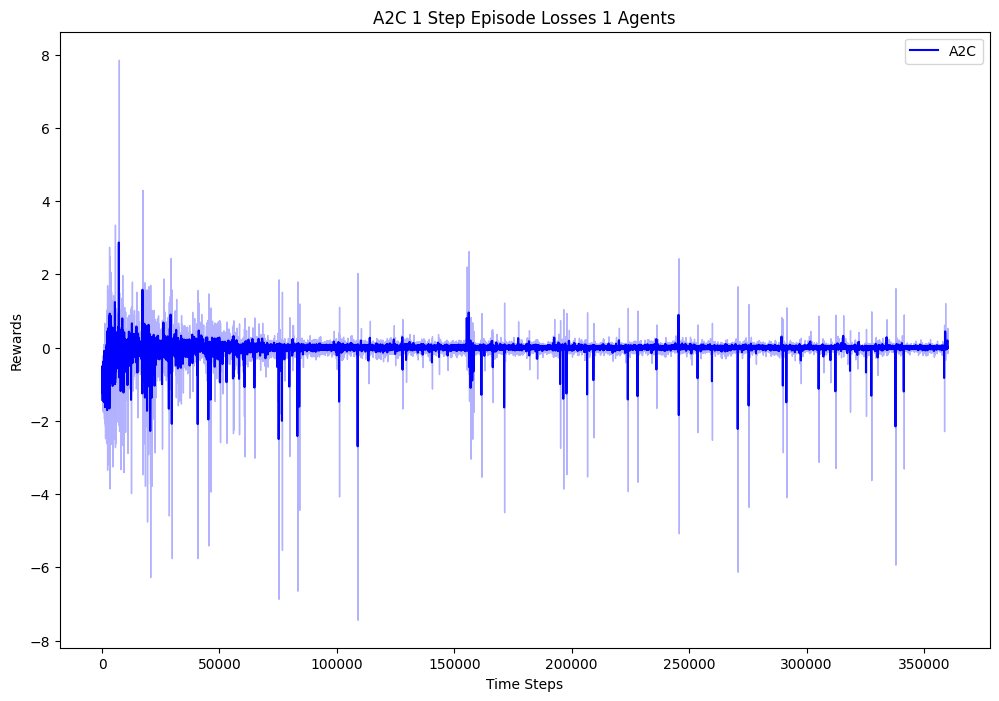

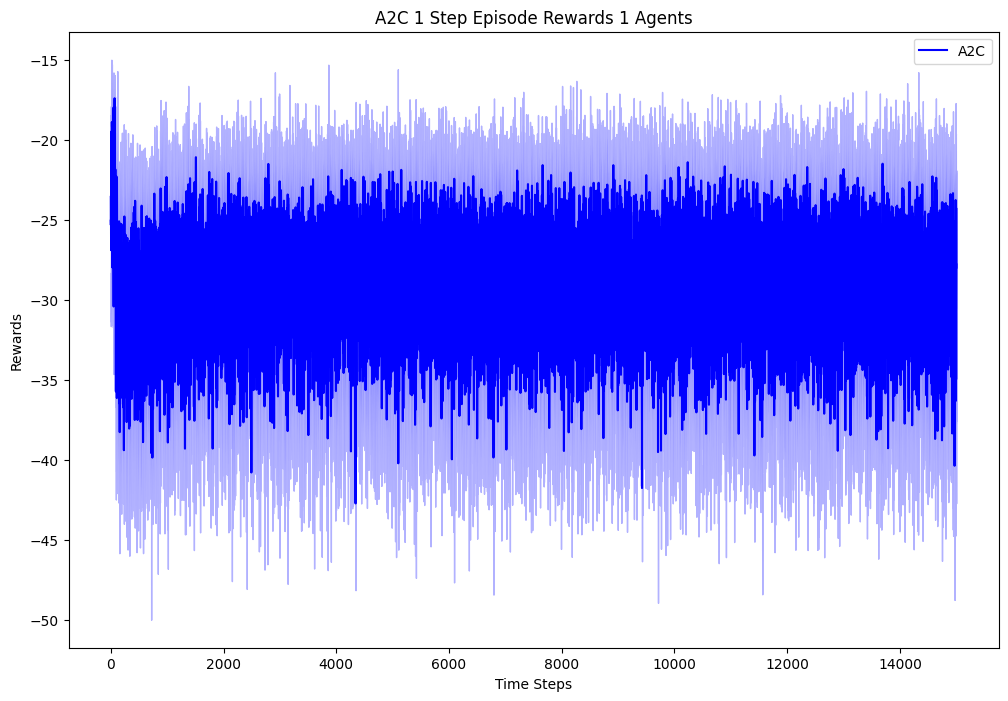

In [104]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Losses 1 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Rewards 1 Agents")

In [109]:
# save episode rewards to a json file
import json

def list_of_np_arrays_to_list_of_lists(arr):
    return [arr[i].tolist() for i in range(len(arr))]

# many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
# many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_1step_rewards1_agent.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses1_agent.json', 'w') as f:
    json.dump(many_run_losses, f)

In [110]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 15000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [-0.70466039 -1.14044806]
Rewards: [-22.50705915 -22.50705915]
Average last 20 Rewards-22.50705915438581
episode: 0
Loss: [ 0.04658751 -0.18351011]
Rewards: [-33.63860281 -33.63860281]
Average last 20 Rewards-29.677466162801853
episode: 1000
Loss: [ 0.00099385 -0.59114555]
Rewards: [-19.7176281 -19.7176281]
Average last 20 Rewards-31.802806244968302
episode: 2000
Loss: [ 0.11650699 -6.02956869]
Rewards: [-54.51524322 -54.51524322]
Average last 20 Rewards-37.02540651874463
episode: 3000
Loss: [ 0.00070521 -0.08731344]
Rewards: [-33.93165183 -33.93165183]
Average last 20 Rewards-34.48734854170423
episode: 4000
Loss: [0.00589462 0.00618896]
Rewards: [-31.71426392 -31.71426392]
Average last 20 Rewards-31.068000195886203
episode: 5000
Loss: [0.00981142 0.08067158]
Rewards: [-29.88125554 -29.88125554]
Average last 20 Rewards-32.34224158554017
episode: 6000
Loss: [0.02036432 0.04991591]
Rewards: [-31.58223068 -31.58223068]
Average last 20 Rewards-32.960671249098276
episode: 7000
Loss: 

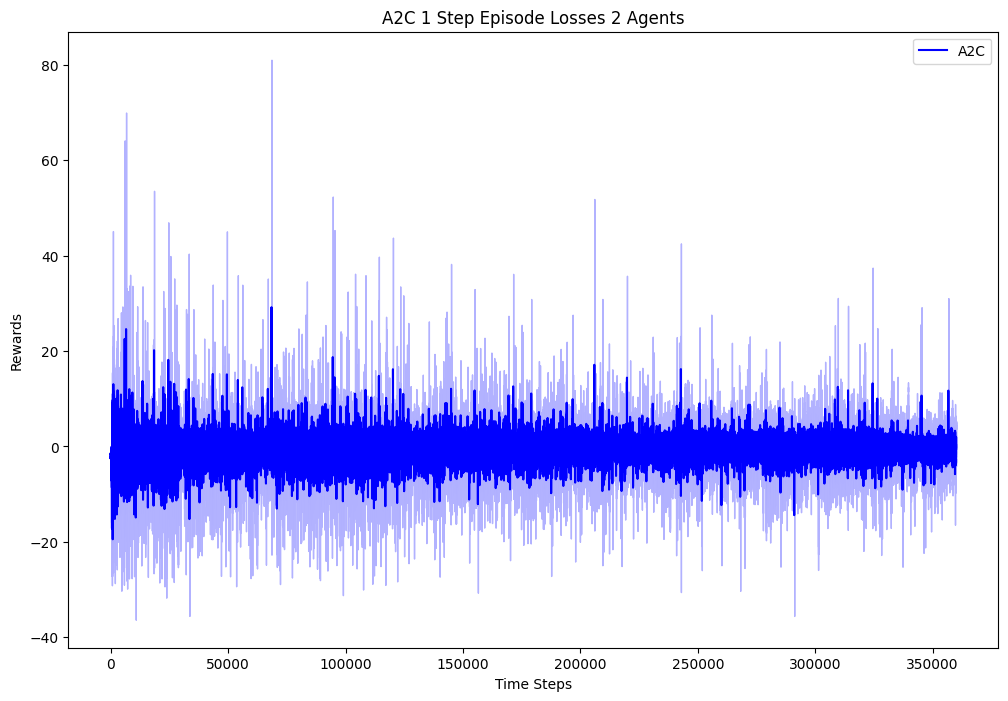

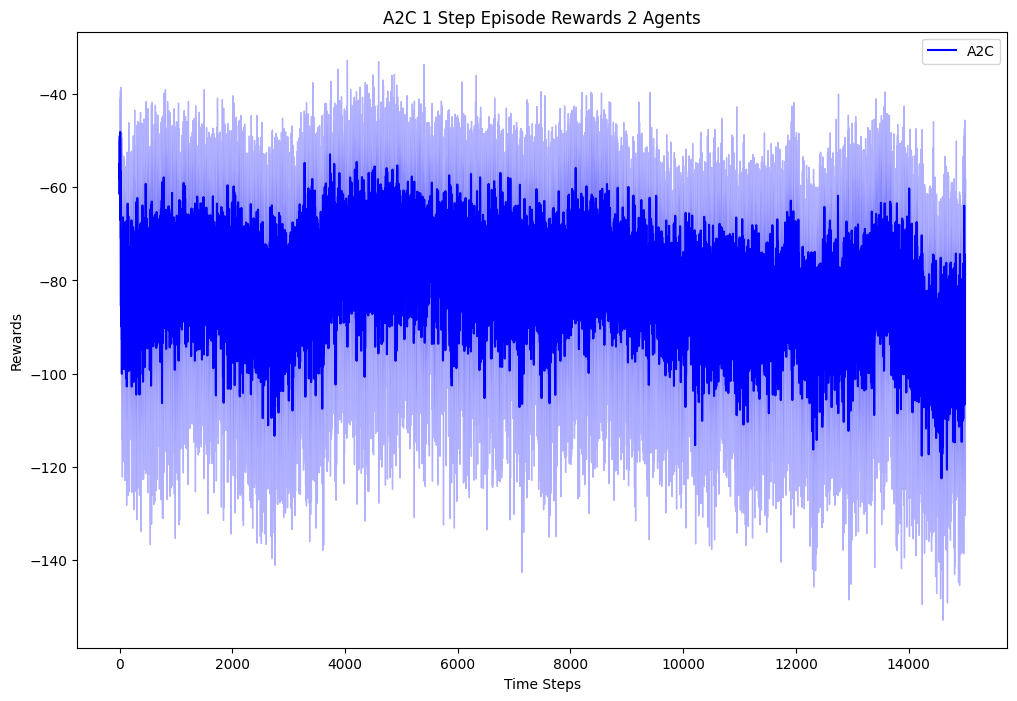

In [111]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Rewards 2 Agents")

In [112]:
def list_of_np_arrays_to_list_of_lists(arr):
    return [arr[i].tolist() for i in range(len(arr))]

many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_1step_rewards2_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses2_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [147]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 35000
    num_agents = 3
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [-0.70937498 -0.74020516 -0.82651935]
Rewards: -80.09627336770595
Average last 20 Rewards-80.09627336770595
episode: 0

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [0.05052812 0.05715411 0.04868995]
Rewards: -110.76472458365802
Average last 20 Rewards-119.66577475008016
episode: 1000
Loss: [2.12905175 2.03622749 2.104109  ]
Rewards: -231.94439525805709
Average last 20 Rewards-190.1835282496126
episode: 2000
Loss: [0.05213536 0.05256491 0.04911687]
Rewards: -238.05409692993706
Average last 20 Rewards-206.57735344981543
episode: 3000
Loss: [  0.34591197 -10.24359522 -10.28829723]
Rewards: -166.53428192919853
Average last 20 Rewards-149.21491597862126
episode: 4000
Loss: [0.03905591 3.78642409 3.74377301]
Rewards: -140.9784463184364
Average last 20 Rewards-184.2184255026613
episode: 5000
Loss: [ 0.00939257 -1.49859412 -1.52500691]
Rewards: -168.81831253440805
Average last 20 Rewards-140.37282283698823
episode: 6000
Loss: [ 0.01205182 -1.75878028 -1.76732384]
Rewards: -154.16620408382343
Average last 20 Rewards-126.8342907131142
episode: 7000
Loss: [ 0.0038043   0.00434224 -1.10331522]
Rewards: -119.92644671425784
Average last 20 Rewards-160.5

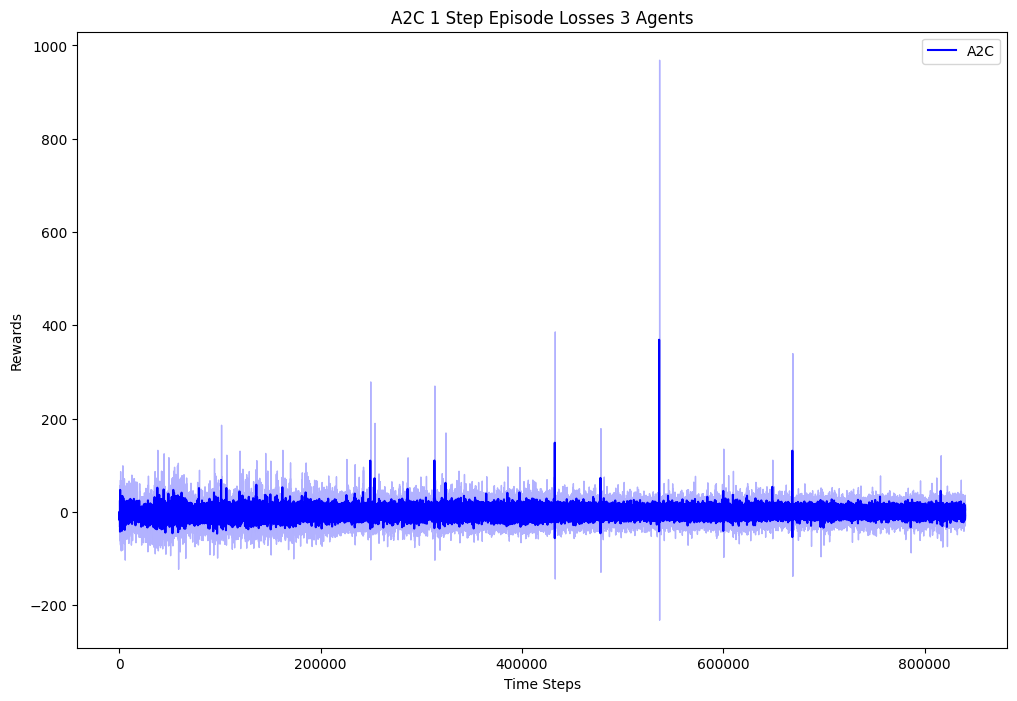

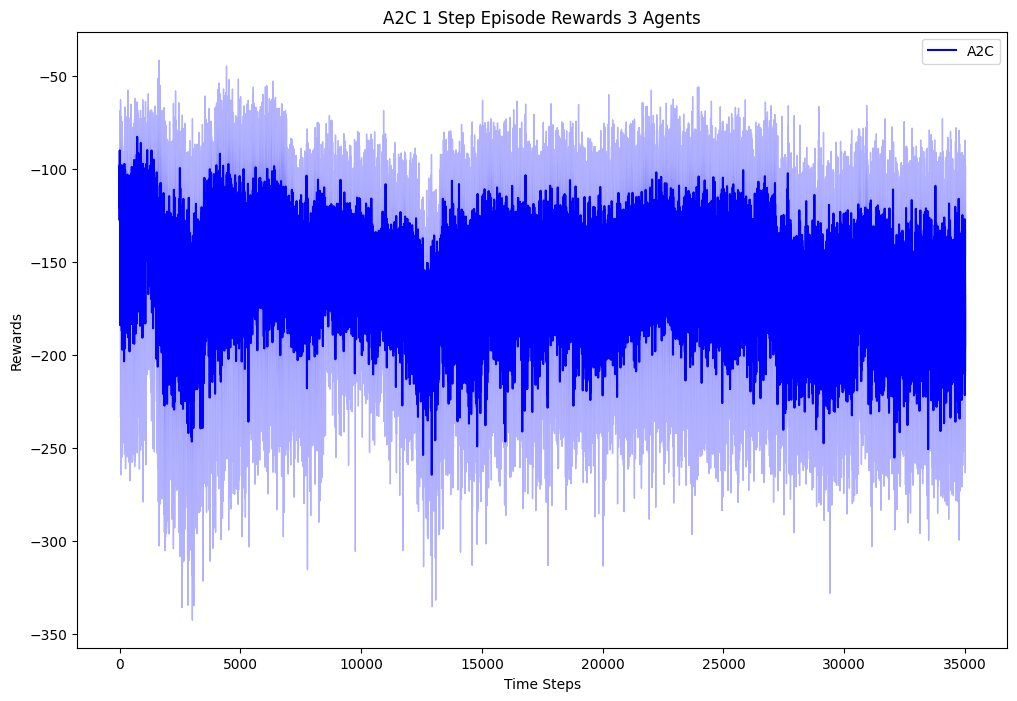

In [148]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Losses 3 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Rewards 3 Agents")

In [149]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)
with open('simple_spread_a2c_1step_rewards3_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses3_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [150]:
if __name__ == '__main__':
    num_steps = 2
    max_episodes = 25000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [0.65352262 0.5025214 ]
Rewards: -58.43365569719846
Average last 20 Rewards-58.43365569719846
episode: 0

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [0.05886759 8.98971206]
Rewards: -55.025846229845854
Average last 20 Rewards-68.6226402363098
episode: 1000
Loss: [0.00289463 0.70646939]
Rewards: -59.74977662415627
Average last 20 Rewards-64.56833222954977
episode: 2000
Loss: [0.00528036 2.14950973]
Rewards: -48.85600121901472
Average last 20 Rewards-65.01137583760676
episode: 3000
Loss: [0.00454243 2.0949576 ]
Rewards: -68.57775792305341
Average last 20 Rewards-68.09477074421173
episode: 4000
Loss: [ 0.04041851 -4.19044259]
Rewards: -56.840069321858685
Average last 20 Rewards-68.85208586228754
episode: 5000
Loss: [ 0.03579977 -2.52064087]
Rewards: -52.90454047730785
Average last 20 Rewards-64.43559943695803
episode: 6000
Loss: [0.00638952 4.11970076]
Rewards: -64.79689448153086
Average last 20 Rewards-71.12031507352737
episode: 7000
Loss: [0.02145336 3.09647256]
Rewards: -41.57803510034954
Average last 20 Rewards-64.24448201638734
episode: 8000
Loss: [ 0.00388492 -2.43933742]
Rewards: -86.60228140785478
Average last 20 Reward

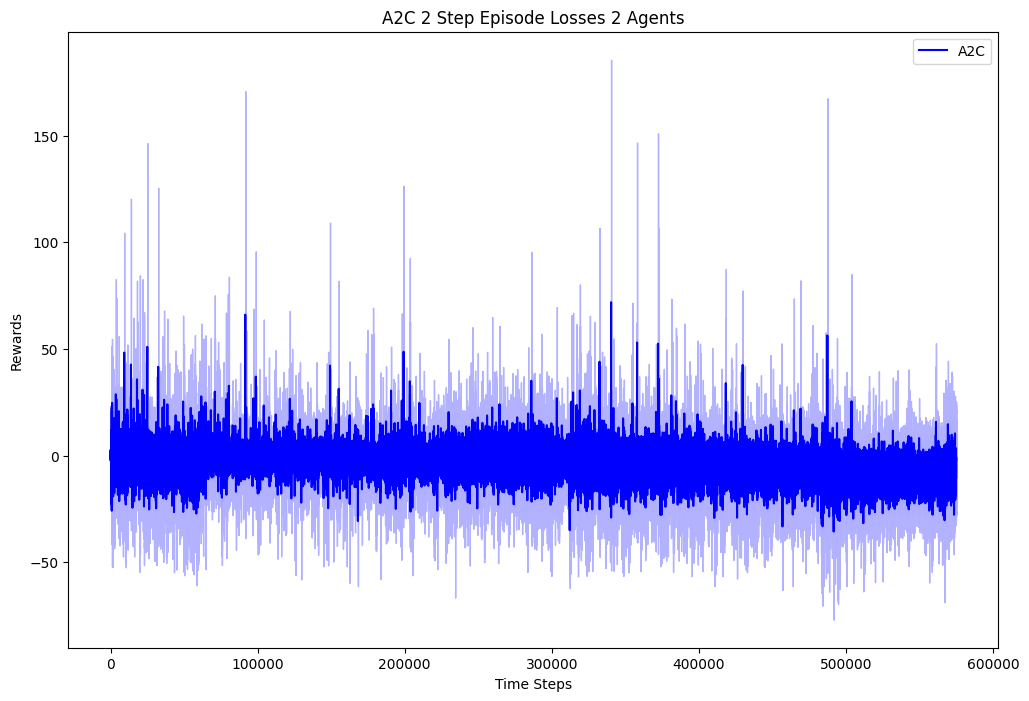

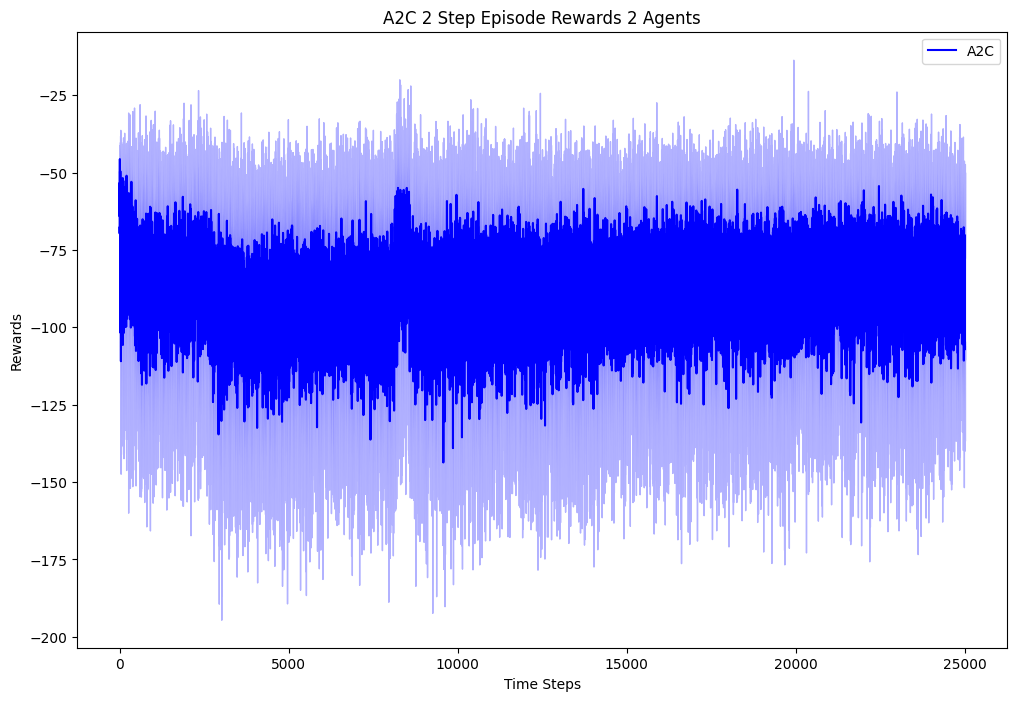

In [151]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 2 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 2 Step Episode Rewards 2 Agents")

In [152]:
with open('simple_spread_a2c_2step_rewards2_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_2step_losses2_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [153]:
if __name__ == '__main__':
    num_steps = 4
    max_episodes = 25000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [4.78295909 4.52346789]
Rewards: -41.78533834781762
Average last 20 Rewards-41.78533834781762
episode: 0
Loss: [0.06359537 0.06435403]
Rewards: -117.57246393393673
Average last 20 Rewards-112.36093750625636
episode: 1000

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [0.74645676 0.74582999]
Rewards: -81.59838915412507
Average last 20 Rewards-100.79713669325035
episode: 2000
Loss: [0.27927607 0.27612329]
Rewards: -119.61555938353733
Average last 20 Rewards-107.9058634186295
episode: 3000
Loss: [1.76810605 3.038362  ]
Rewards: -140.3080336460168
Average last 20 Rewards-91.60775567778335
episode: 4000
Loss: [0.07594537 0.07631377]
Rewards: -106.93586738174993
Average last 20 Rewards-92.95221721624746
episode: 5000
Loss: [ 1.96261236 -4.79093373]
Rewards: -125.99060451076078
Average last 20 Rewards-100.99111260584749
episode: 6000
Loss: [1.74628757e-02 2.31346957e+01]
Rewards: -116.51847404341272
Average last 20 Rewards-97.47945079939984
episode: 7000
Loss: [3.76390512e-05 9.62312363e-05]
Rewards: -82.8309534412932
Average last 20 Rewards-97.01403044537652
episode: 8000
Loss: [0.10070842 5.88900467]
Rewards: -88.78806993211307
Average last 20 Rewards-98.38349503158172
episode: 9000
Loss: [ 1.88301907 31.46116392]
Rewards: -44.9767133462978
Avera

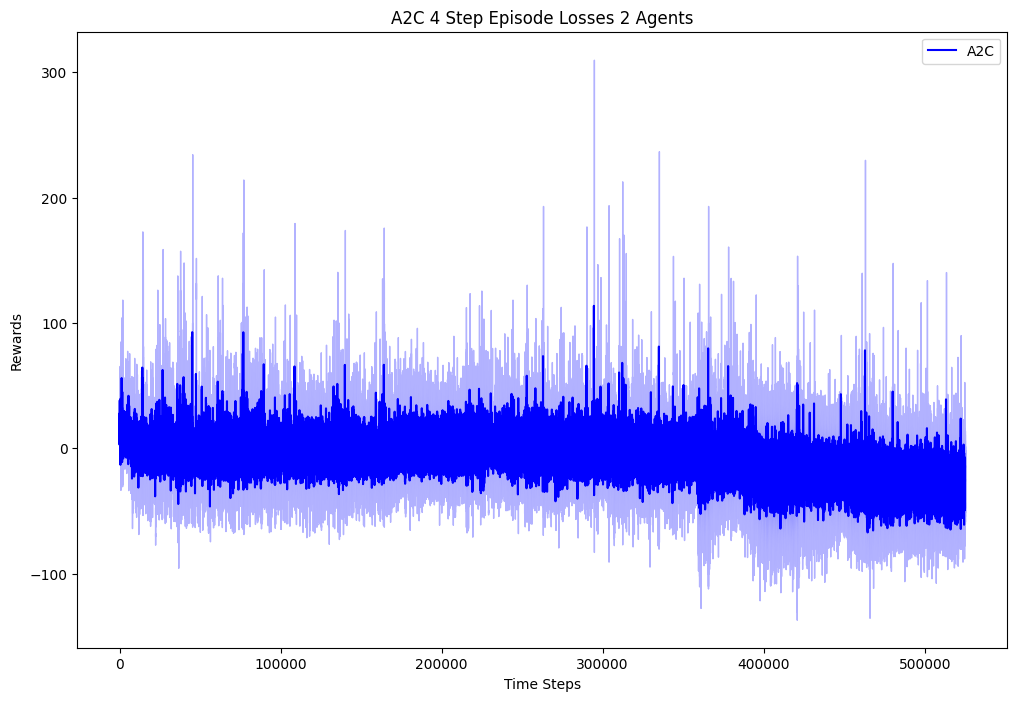

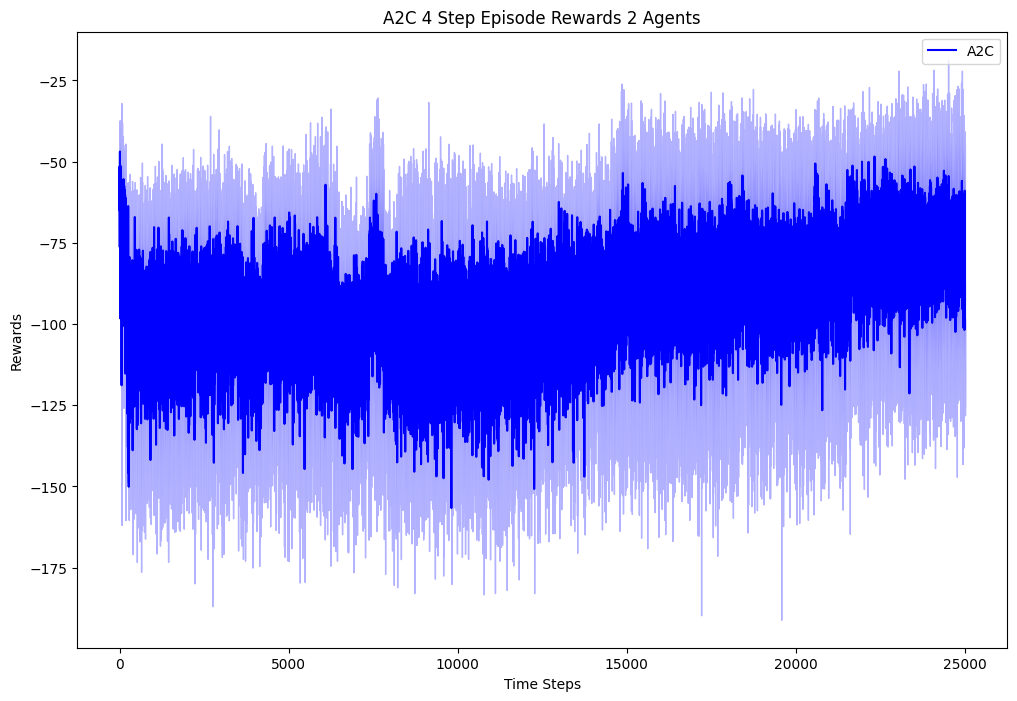

In [154]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Losses", "A2C 4 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 4 Step Episode Rewards 2 Agents")

In [155]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_4step_rewards2_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_4step_losses2_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [156]:
if __name__ == '__main__':
    num_steps = 8
    max_episodes = 30000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [30.74139504 32.13530277]
Rewards: -48.775789746271094
Average last 20 Rewards-48.775789746271094
episode: 0
Loss: [0.37387104 0.30717397]
Rewards: -127.72404869388518
Average last 20 Rewards-118.01329773532241
episode: 1000
Loss: [7.43659807 7.38563616]
Rewards: -101.66671001855245
Average last 20 Rewards-108.02503519643824
episode: 2000

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [0.00080939 0.00100974]
Rewards: -99.01910823061438
Average last 20 Rewards-101.8106518033083
episode: 3000
Loss: [0.12870584 0.13471725]
Rewards: -69.29107650354408
Average last 20 Rewards-95.94830486573473
episode: 4000
Loss: [0.98997232 0.98483141]
Rewards: -141.53430123769883
Average last 20 Rewards-100.37416759350137
episode: 5000
Loss: [0.84674671 0.85179539]
Rewards: -132.81069951078535
Average last 20 Rewards-106.21780702756806
episode: 6000
Loss: [0.22400421 0.25838006]
Rewards: -83.7243094994161
Average last 20 Rewards-102.03252201456924
episode: 7000
Loss: [0.51798016 0.52090697]
Rewards: -81.20503168353036
Average last 20 Rewards-105.01980124328747
episode: 8000
Loss: [0.16377493 0.1709506 ]
Rewards: -87.65405464016555
Average last 20 Rewards-91.32532160120559
episode: 9000
Loss: [0.48541981 0.48656312]
Rewards: -80.9487234174379
Average last 20 Rewards-108.928166055586
episode: 10000
Loss: [0.01558955 0.01470755]
Rewards: -117.88472081253558
Average last 20 Rewards-

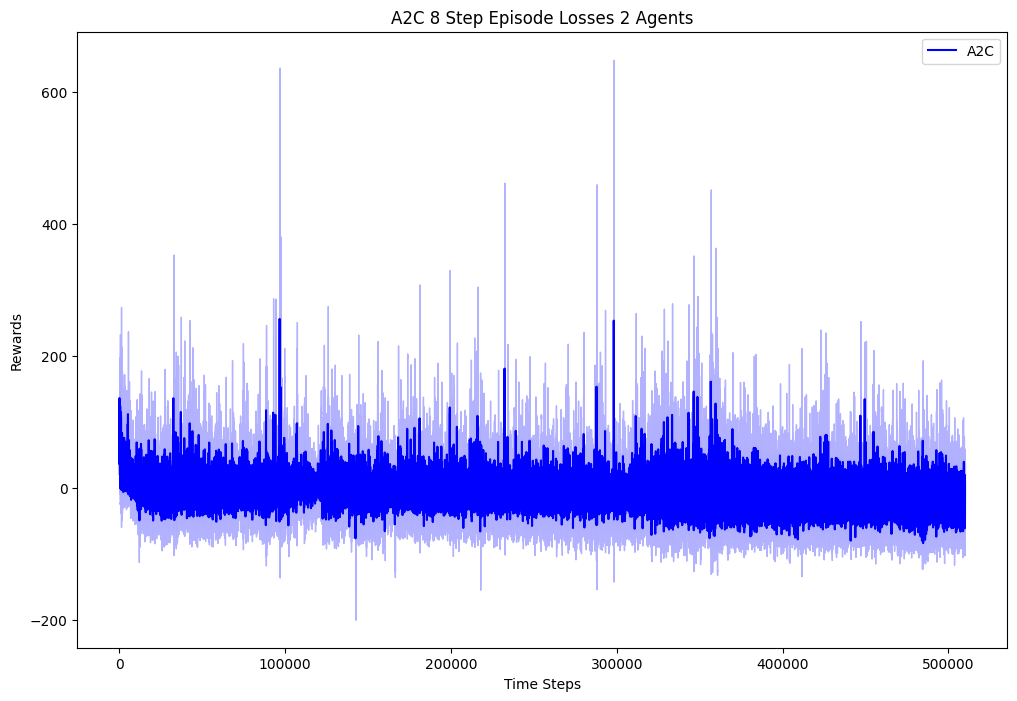

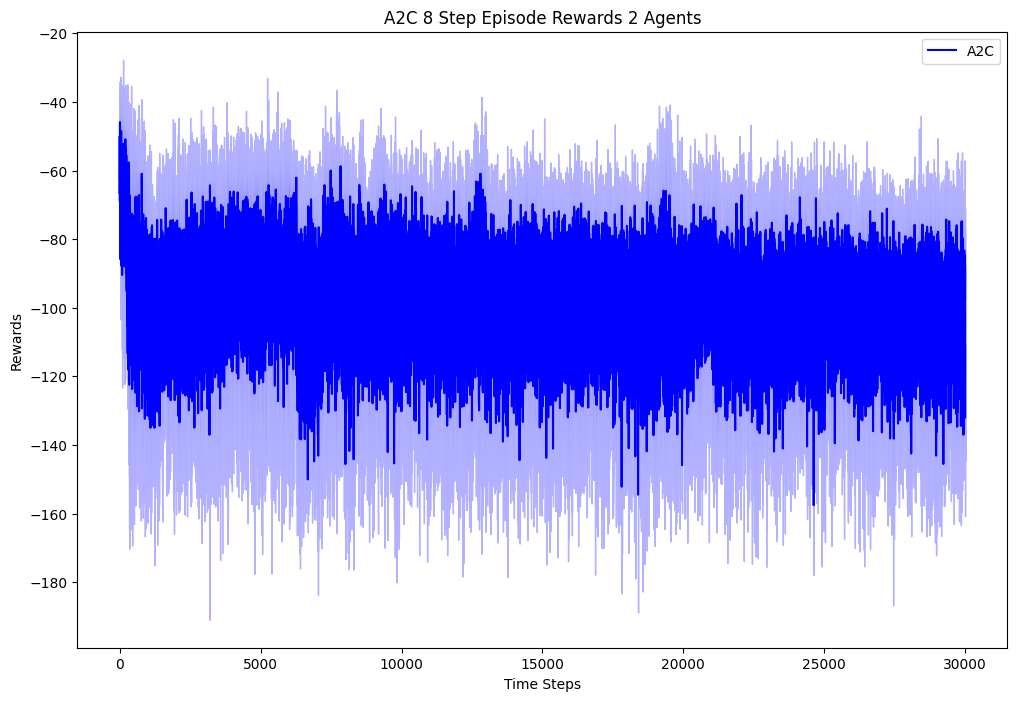

In [157]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 8 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 8 Step Episode Rewards 2 Agents")

In [158]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_rewards2_agents_8_steps.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_losses2_agents_8_steps.json', 'w') as f:
    json.dump(many_run_losses, f)

In [159]:
if __name__ == '__main__':
    num_steps = 4
    max_episodes = 35000
    num_agents = 3
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [17.56064882 16.91141674 12.42060151]
Rewards: -102.89381182907537
Average last 20 Rewards-102.89381182907537
episode: 0
Loss: [0.01793058 0.01833229 0.01893094]
Rewards: -178.2181819029777
Average last 20 Rewards-191.5160406035163
episode: 1000

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [3.38348772 3.38700149 3.38639588]
Rewards: -179.24612114495028
Average last 20 Rewards-200.39761944858245
episode: 2000
Loss: [0.01814348 0.01016711 0.01297925]
Rewards: -165.64364079988636
Average last 20 Rewards-203.12730378347334
episode: 3000
Loss: [2.64068644 2.72613137 2.6399238 ]
Rewards: -213.01633193513294
Average last 20 Rewards-189.32765336558197
episode: 4000
Loss: [0.1184758  0.16162862 0.13401435]
Rewards: -122.50320481628141
Average last 20 Rewards-195.96428310866315
episode: 5000
Loss: [ 3.47319935 -6.13470631 -6.94408481]
Rewards: -203.71347351857685
Average last 20 Rewards-183.2503293086864
episode: 6000
Loss: [2.04645253 2.05062209 1.9966039 ]
Rewards: -212.53924397230696
Average last 20 Rewards-193.10617520473556
episode: 7000
Loss: [1.15685693 1.10149509 1.12435657]
Rewards: -212.87694531179335
Average last 20 Rewards-187.59322392644938
episode: 8000
Loss: [2.13044509 1.98869132 2.12698969]
Rewards: -221.08087142790515
Average last 20 Rewards-204.5586588673

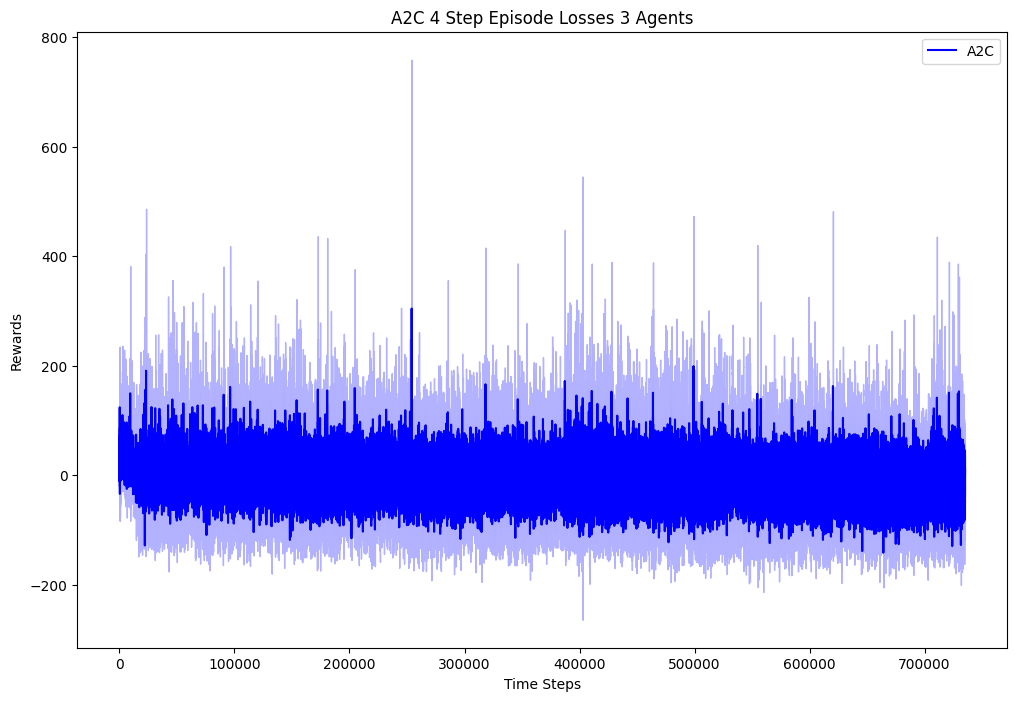

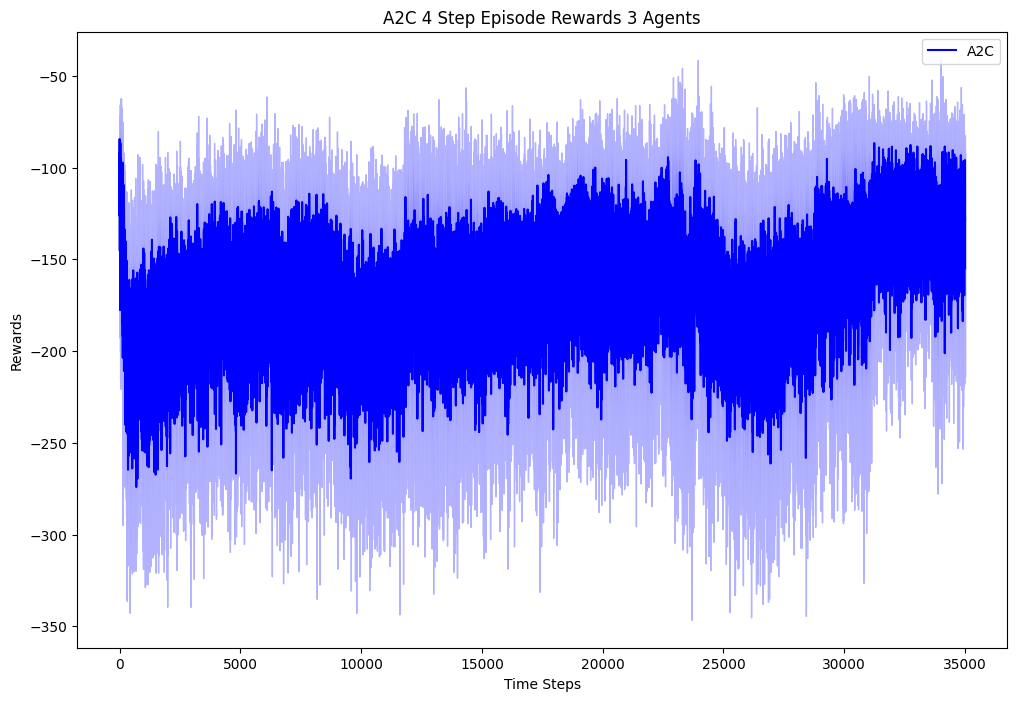

In [160]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 4 Step Episode Losses 3 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 4 Step Episode Rewards 3 Agents")

In [161]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_rewards3_agents_4_steps.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_losses_3_agents_4steps.json', 'w') as f:
    json.dump(many_run_losses, f)

In [162]:
if __name__ == '__main__':
    num_steps = 8
    max_episodes = 30000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents, use_entropy=True)


Loss: [15.53857951 16.56494708]
Rewards: -51.4397476509694
Average last 20 Rewards-51.4397476509694
episode: 0
Loss: [0.78596775 0.80625886]
Rewards: -92.28039254390134
Average last 20 Rewards-115.06305146103398
episode: 1000
Loss: [1.73283579 1.81028111]
Rewards: -87.94917233157233
Average last 20 Rewards-109.48582829824689
episode: 2000
Loss: [0.1557464  0.15117557]
Rewards: -134.4802468020608
Average last 20 Rewards-116.23988084920923
episode: 3000
Loss: [0.38036157 0.37797112]
Rewards: -100.1610904747645
Average last 20 Rewards-110.99352456267755
episode: 4000
Loss: [0.9077621  0.88277141]
Rewards: -78.04345307427015
Average last 20 Rewards-110.02818840886121
episode: 5000
Loss: [3.15263707 3.26534814]
Rewards: -111.5380258698081
Average last 20 Rewards-110.98141135011697
episode: 6000
Loss: [0.08568516 0.08440813]
Rewards: -80.06791139605697
Average last 20 Rewards-113.15072787007742
episode: 7000
Loss: [0.09773574 0.09778313]
Rewards: -111.72208404939994
Average last 20 Rewards-

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [3.7056079  3.75790432]
Rewards: -102.81559350715789
Average last 20 Rewards-115.203252947806
episode: 2000
Loss: [inf inf]
Rewards: -88.34752354415347
Average last 20 Rewards-115.1902509879175
episode: 3000
Loss: [0.23926418 0.23531256]
Rewards: -119.08024139062978
Average last 20 Rewards-112.61660296573393
episode: 4000
Loss: [0.16276404 0.15031128]
Rewards: -149.18377414806776
Average last 20 Rewards-110.84694921127493
episode: 5000
Loss: [inf inf]
Rewards: -103.28762085178147
Average last 20 Rewards-98.82597834789634
episode: 6000
Loss: [  2.73369574 -13.04911755]
Rewards: -89.18115190907133
Average last 20 Rewards-90.48117950083406
episode: 7000
Loss: [0.35955466 1.02430937]
Rewards: -85.60578699930976
Average last 20 Rewards-81.63329575777995
episode: 8000
Loss: [0.12542884 0.12635821]
Rewards: -68.27091181073051
Average last 20 Rewards-74.2978133688067
episode: 9000
Loss: [inf inf]
Rewards: -109.24343909285854
Average last 20 Rewards-107.49019165676536
episode: 10000
Loss

/home/douglas/code/CS5180-project/venv/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


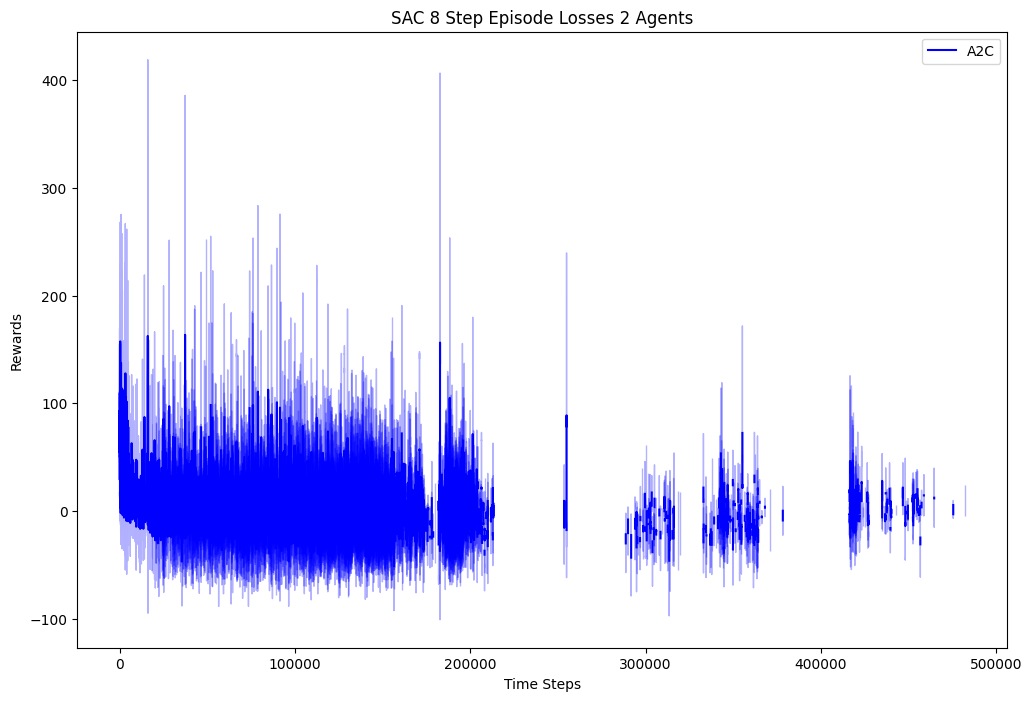

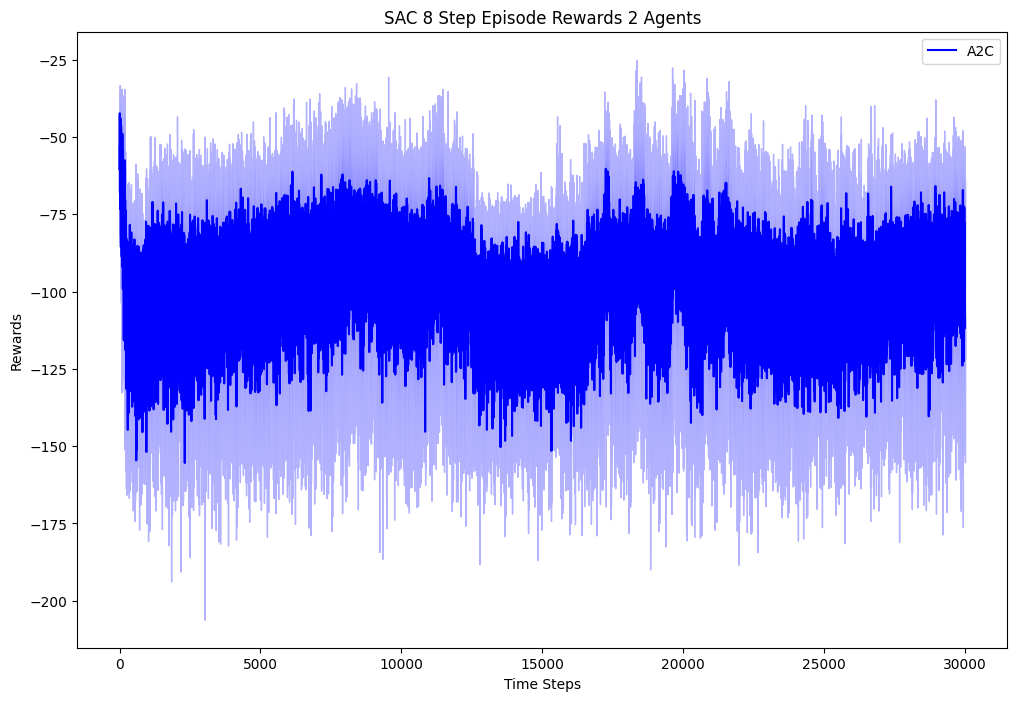

In [163]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "SAC 8 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "SAC 8 Step Episode Rewards 2 Agents")

In [164]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_sac_rewards2_agents_8_steps.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_sac_losses_2_agents_8steps.json', 'w') as f:
    json.dump(many_run_losses, f)

In [165]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 30000
    num_agents = 3
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents, use_entropy=True)


Loss: [-0.87061994 -0.99478057 -0.82978379]
Rewards: -77.74735837927366
Average last 20 Rewards-77.74735837927366
episode: 0
Loss: [ 0.0807425  -1.62926811 -1.82943422]
Rewards: -191.08321187828741
Average last 20 Rewards-196.55746609742255
episode: 1000

/tmp/ipykernel_17838/136240406.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [0.146517   0.15155755 0.148323  ]
Rewards: -117.43654512527772
Average last 20 Rewards-162.82124836442054
episode: 2000
Loss: [inf inf inf]
Rewards: -131.7462681560898
Average last 20 Rewards-130.39559645070153
episode: 3000
Loss: [inf inf inf]
Rewards: -137.3871977659938
Average last 20 Rewards-139.40267888033353
episode: 4000
Loss: [inf inf inf]
Rewards: -204.93484685587006
Average last 20 Rewards-168.3219260376078
episode: 5000
Loss: [0.80306929 0.79861761 0.79845795]
Rewards: -190.2052216258567
Average last 20 Rewards-141.79675258450058
episode: 6000
Loss: [inf inf inf]
Rewards: -151.44826383390776
Average last 20 Rewards-148.1199512867501
episode: 7000
Loss: [inf inf inf]
Rewards: -206.33807216201117
Average last 20 Rewards-177.4839904755783
episode: 8000
Loss: [inf inf inf]
Rewards: -117.30858800125326
Average last 20 Rewards-161.48806342464502
episode: 9000
Loss: [inf inf inf]
Rewards: -129.25878599427605
Average last 20 Rewards-190.4244819252088
episode: 10000
Loss: [in

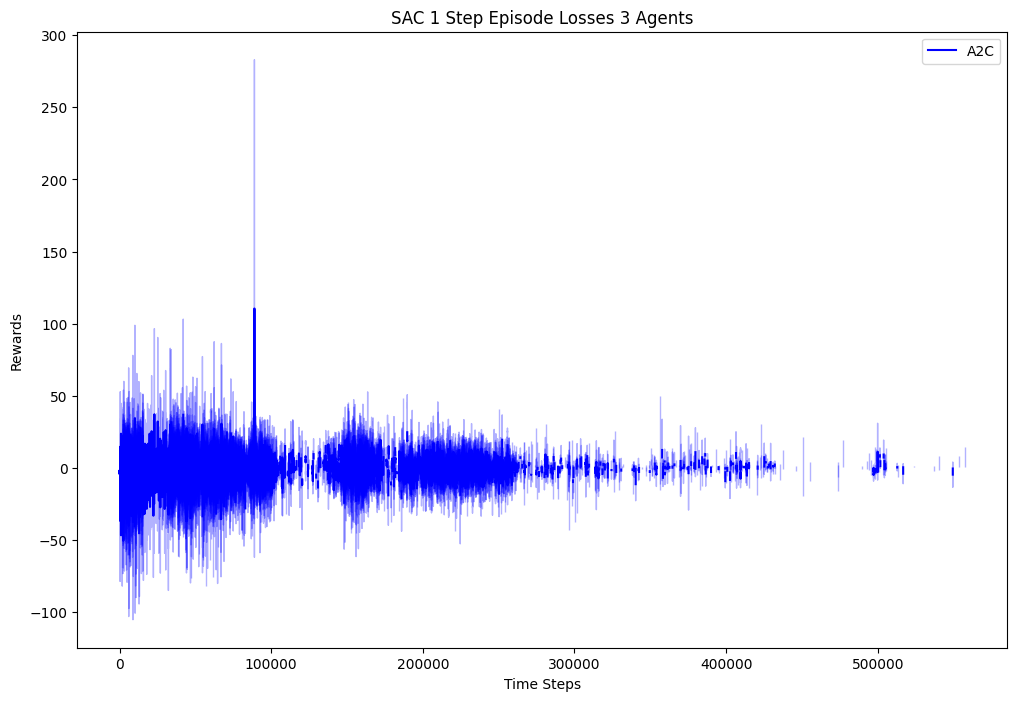

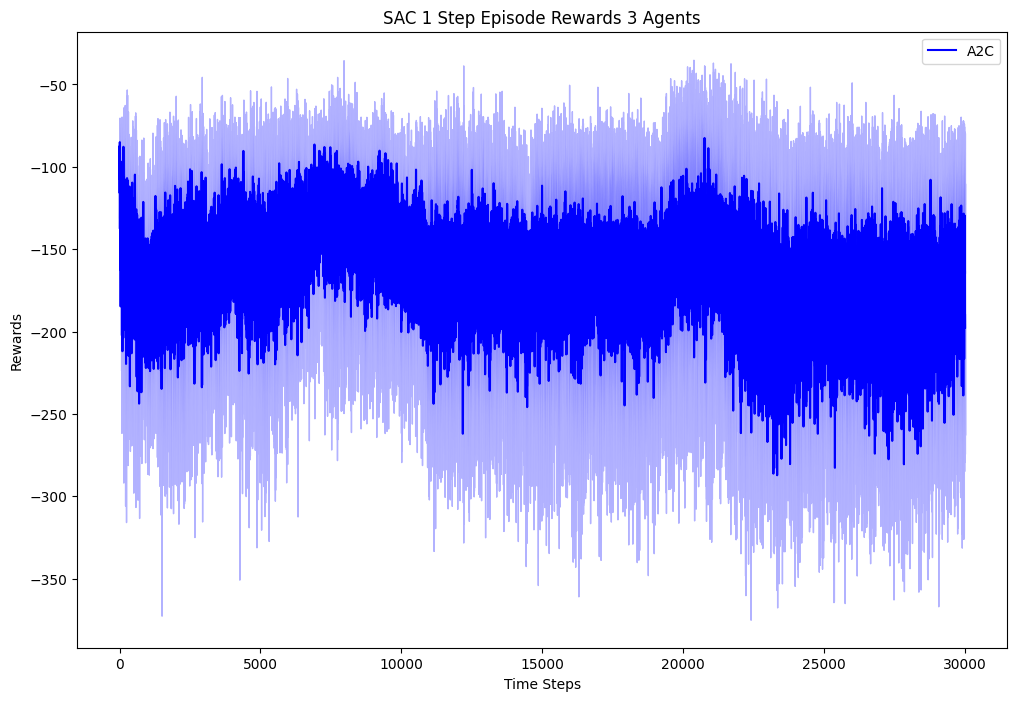

In [166]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "SAC 1 Step Episode Losses 3 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "SAC 1 Step Episode Rewards 3 Agents")

In [167]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_sac_rewards3_agents_1_steps.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_sac_losses_3_agents_1steps.json', 'w') as f:
    json.dump(many_run_losses, f)

In [177]:
if __name__ == '__main__':
    num_steps = 4
    max_episodes = 40000
    num_agents = 3
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents, use_entropy=True)


Loss: [20.17522638 19.47727105 20.5428399 ]
Rewards: -99.40113794942458
Average last 20 Rewards-99.40113794942458
episode: 0
Loss: [2.85239648 2.72474466 2.85358595]
Rewards: -152.92344396745946
Average last 20 Rewards-188.3221910850062
episode: 1000

/tmp/ipykernel_17838/838528731.py:126: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))



Loss: [0.96617515 1.00983652 0.97773417]
Rewards: -205.15131374379732
Average last 20 Rewards-183.08641266753042
episode: 2000
Loss: [1.28056721 1.30960705 1.31581723]
Rewards: -216.40514892541387
Average last 20 Rewards-202.66845961897695
episode: 3000
Loss: [2.78565322 2.7437278  2.69144155]
Rewards: -210.31751933010207
Average last 20 Rewards-176.98947933637126
episode: 4000
Loss: [0.13509161 0.14659317 0.14772083]
Rewards: -156.11015828288274
Average last 20 Rewards-167.5791045178375
episode: 5000
Loss: [0.36925868 0.34284741 0.36703938]
Rewards: -147.6532286219509
Average last 20 Rewards-170.4127648865987
episode: 6000
Loss: [0.43160301 0.43373747 0.44159455]
Rewards: -156.93925251855552
Average last 20 Rewards-157.50755581595078
episode: 7000
Loss: [0.00332948 0.00432402 0.00967344]
Rewards: -165.6432088828006
Average last 20 Rewards-193.16155226172813
episode: 8000
Loss: [0.70594262 0.70334549 0.69238635]
Rewards: -115.12384307979966
Average last 20 Rewards-159.1854310611431
ep

In [ ]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Losses", "SAC 4 Step Episode Losses 3 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "SAC 4 Step Episode Rewards 3 Agents")

In [ ]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_sac_rewards3_agents_4_steps.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_sac_losses_3_agents_4steps.json', 'w') as f:
    json.dump(many_run_losses, f)